In [1]:
%pip install torch numpy pandas fastai

Note: you may need to restart the kernel to use updated packages.


RANDOM FOREST

In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('./Titanic/train.csv')
tst_df = pd.read_csv('./Titanic/test.csv')
modes = df.mode().iloc[0]

def proc_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)
    

proc_data(df)
proc_data(tst_df)

random.seed(42)
trn_df,val_df = train_test_split(df,test_size=0.2)

cats=['Sex','Embarked']
conts=['Age','SibSp','Parch','LogFare','Pclass']
dep="Survived"

In [2]:
cols = cats + conts
cols.remove("Sex")
ismale = trn_df.Sex == 1
males,females = trn_df[ismale],trn_df[~ismale]

In [3]:
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)
def xs_y(df):
    xs = df[cats+conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [4]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs,trn_y)

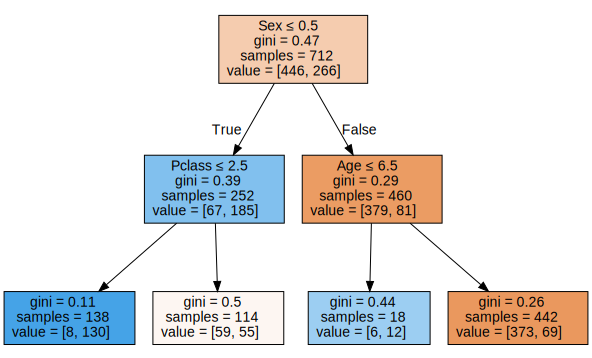

In [10]:
import re
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=False, precision=precision)
    return graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s))
    
draw_tree(m, trn_xs, precision=2)

In [5]:
m = DecisionTreeClassifier(min_samples_leaf=50).fit(trn_xs,trn_y)
draw_tree(m, trn_xs, size=25)

NameError: name 'draw_tree' is not defined

In [12]:
tst_df[cats] = tst_df[cats].apply(lambda x: x.cat.codes)
tst_xs,_ = xs_y(tst_df)

def subm(preds,suff):
    tst_df['Survived'] = preds
    tst_df[['PassengerId','Survived']].to_csv(f'subm_{suff}.csv',index=False)
    sub_df = tst_df[['PassengerId','Survived']]
    sub_df.to_csv(f'subm_{suff}.csv',index=False)
    
subm(m.predict(tst_xs),'tree')

In [7]:
from sklearn.metrics import mean_absolute_error
def get_tree(prop=0.75):
    n = len(trn_y)
    idxs = random.sample(range(n), int(n*prop))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(trn_xs.iloc[idxs],trn_y.iloc[idxs])

trees = [get_tree() for i in range(100)]

all_props = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_props).mean(0)

mean_absolute_error(val_y,avg_probs)

0.2039664804469274

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100,min_samples_leaf=5).fit(trn_xs,trn_y)
mean_absolute_error(val_y,rf.predict(val_xs))

0.18994413407821228

<AxesSubplot:ylabel='cols'>

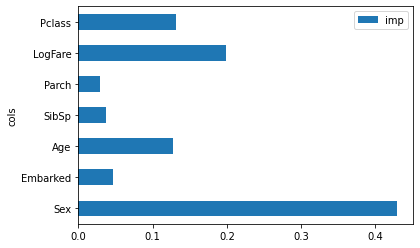

In [26]:
pd.DataFrame(dict(cols=trn_xs.columns,imp=rf.feature_importances_)).plot('cols','imp','barh')

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


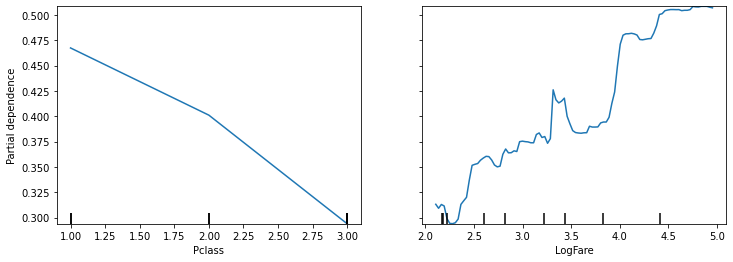

In [31]:
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
fig,ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(rf,val_xs,['Pclass','LogFare'],ax=ax)

In [32]:
%pip install treeinterpreter
%pip install waterfallcharts

Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3389 sha256=b3883e59a3700bb7a5701bc0126fdf68d6afecb2f11e1cbef7a2c76a40141dbe
  Stored in directory: /root/.cache/pip/wheels/3a/f4/33/2b1d12e4f5fb584718fce4ed86786549815863ef7276ff1415
Successfully built waterfallcharts
Note: you may need to restart the kernel to use updated packages.


In [17]:
from treeinterpreter import treeinterpreter
row = val_xs.iloc[:5]

prediction,bias,contributions= treeinterpreter.predict(rf,row.values)

In [18]:
prediction[0], bias[0], contributions[0].sum()

(array([0.84382695, 0.15617305]),
 array([0.61345506, 0.38654494]),
 2.7755575615628914e-17)

['Sex' 'Embarked' 'Age' 'SibSp' 'Parch' 'LogFare' 'Pclass']


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

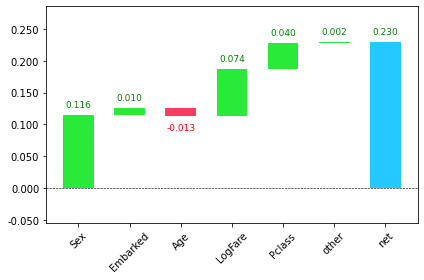

In [37]:
from waterfall_chart import plot as waterfall
print(val_xs.columns.values)
waterfall(val_xs.columns,contributions[0][:, 0], threshold=0.08,rotation_value=45,formatting='{:,.3f}')

PADDY DISEASE CLASSIFICATION

In [2]:

from pathlib import Path
from fastai.vision.all import *

path = Path("./paddy-disease-classification")
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train_images'),Path('paddy-disease-classification/train.csv')]

In [3]:
trn_path = path/'train_images'
files = get_image_files(trn_path)

(480, 640)


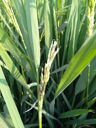

In [45]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [47]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f,files,n_workers=12)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

In [4]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(480,method='squish'),batch_tfms=aug_transforms(size=128,min_scale=0.75))

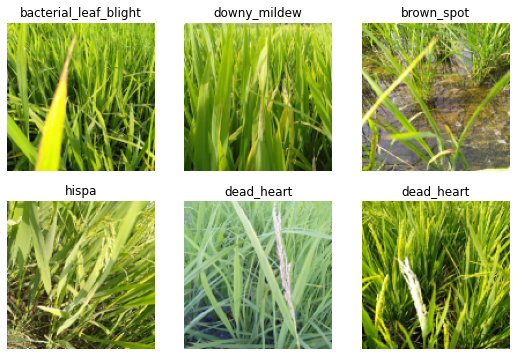

In [49]:
dls.show_batch(max_n=6)

In [7]:
%pip install --upgrade timm  huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.8.1
    Uninstalling huggingface-hub-0.8.1:
      Successfully uninstalled huggingface-hub-0.8.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
from huggingface_hub import *
learn = vision_learner(dls, 'resnet26d',metrics=error_rate,path='.').to_fp16()

SuggestedLRs(valley=0.0014454397605732083, slide=0.004365158267319202)

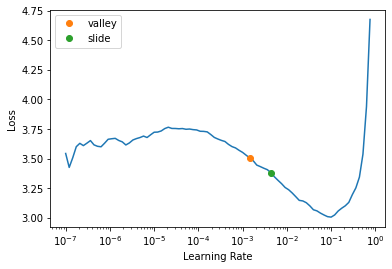

In [7]:
learn.lr_find(suggest_funcs=(valley,slide))

In [8]:
learn.fine_tune(3,0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.780842,1.298967,0.422874,00:36


epoch,train_loss,valid_loss,error_rate,time
0,1.120070,0.818012,0.265738,00:41
1,0.777741,0.464512,0.149928,00:42
2,0.536961,0.381855,0.120615,00:41


In [9]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

,image_id,label
0,200001.jpg,NaN
1,200002.jpg,NaN
2,200003.jpg,NaN
3,200004.jpg,NaN
4,200005.jpg,NaN
...,...,...
3464,203465.jpg,NaN
3465,203466.jpg,NaN
3466,203467.jpg,NaN
3467,203468.jpg,NaN


In [11]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = dls.test_dl(tst_files)

In [12]:
probs,_,idxs= learn.get_preds(dl=tst_dl,with_decoded=True)
idxs

TensorBase([7, 8, 4,  ..., 8, 1, 5])

In [13]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

In [14]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(),name="idxs").map(mapping)
results

0                       hispa
1                      normal
2                  brown_spot
3                       blast
4                       blast
                ...          
3464               dead_heart
3465                    hispa
3466                   normal
3467    bacterial_leaf_streak
3468               dead_heart
Name: idxs, Length: 3469, dtype: object

In [22]:
ss['label'] = results
ss

,image_id,label
0,200001.jpg,hispa
1,200002.jpg,normal
2,200003.jpg,brown_spot
3,200004.jpg,blast
4,200005.jpg,blast
...,...,...
3464,203465.jpg,dead_heart
3465,203466.jpg,hispa
3466,203467.jpg,normal
3467,203468.jpg,bacterial_leaf_streak


In [23]:
ss.to_csv('submission.csv',index=False)

In [27]:
iskaggle= False
if not iskaggle:
    from kaggle import api
    api.competition_submit('submission.csv','initial rn26d','paddy-disease-classification')

100%|██████████| 70.3k/70.3k [00:00<00:00, 145kB/s]


In [33]:
trn_path = Path('sml')

resize_images(path/'train_images', dest=trn_path,max_size=256,recurse=True)

In [34]:
dls= ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=Resize(256,method='squish'),batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [36]:
def train(arch,item,batch,epochs = 5):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, seed=42, item_tfms=item,batch_tfms=batch)
    learn = vision_learner(dls, arch,metrics=error_rate,path='.').to_fp16()
    learn.fine_tune(epochs,0.01)
    return learn

learn = train('resnet26d',Resize(192,method='squish'),aug_transforms(size=128,min_scale=0.75),3)

epoch,train_loss,valid_loss,error_rate,time
0,1.817355,1.585274,0.496396,00:25


epoch,train_loss,valid_loss,error_rate,time
0,1.180562,0.940550,0.303220,00:30
1,0.834529,0.543696,0.185007,00:30
2,0.574650,0.449769,0.149928,00:29


In [37]:
arch = 'convnext_small_in22k'

learn = train(arch,Resize(192),aug_transforms(size=128,min_scale=0.75))

/usr/local/lib/python3.9/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.298573,0.716553,0.238827,01:17


epoch,train_loss,valid_loss,error_rate,time
0,0.696542,0.432613,0.141278,02:19
1,0.555250,0.330744,0.103316,02:19
2,0.375543,0.256985,0.080730,02:19
3,0.232812,0.172356,0.052379,02:19
4,0.153309,0.162636,0.048054,02:20
